# SC549 – Neural Networks (2024/25)
## Assignment: Player Tracking in Football Videos

**Student Name:** [Your Name]  
**Student ID:** [Your ID]  
**Date:** February 2026

---

## Project Overview

This notebook implements a complete player tracking system for football videos using:
- **YOLOv8** for player detection
- **YOLOv8-Pose** for keypoint detection
- **ByteTrack/SORT** for optional tracking (future enhancement)

### Project Structure
```
SC549_Player_Tracking/
│
├── dataset/
│   ├── videos/              # Input football videos
│   └── dataset.yaml         # Dataset configuration
│
├── models/                  # Pre-trained and fine-tuned models
│
├── outputs/                 # All results saved here
│   ├── detection/           # Detection results
│   ├── pose/                # Pose estimation results
│   └── tracking/            # Tracking results (optional)
│
├── notebooks/               # This notebook
│
├── report/                  # Academic report and figures
│
└── README.md                # Project documentation
```

In [1]:

from google.colab import drive
import os

drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/player tracking'

print(f"✓ Google Drive mounted successfully")
print(f"✓ Base directory: {BASE_DIR}")

Mounted at /content/drive
✓ Google Drive mounted successfully
✓ Base directory: /content/drive/MyDrive/player tracking


In [2]:


import os

DIRECTORIES = {
    'base': BASE_DIR,
    'dataset': os.path.join(BASE_DIR, 'dataset'),
    'videos': os.path.join(BASE_DIR, 'dataset', 'videos'),
    'models': os.path.join(BASE_DIR, 'models'),
    'outputs': os.path.join(BASE_DIR, 'outputs'),
    'detection': os.path.join(BASE_DIR, 'outputs', 'detection'),
    'pose': os.path.join(BASE_DIR, 'outputs', 'pose'),
    'tracking': os.path.join(BASE_DIR, 'outputs', 'tracking'),
    'notebooks': os.path.join(BASE_DIR, 'notebooks'),
    'report': os.path.join(BASE_DIR, 'report')
}


print("Creating project directory structure...\n")
for name, path in DIRECTORIES.items():
    os.makedirs(path, exist_ok=True)
    print(f"✓ Created: {name:12} -> {path}")


print("Project structure created successfully!")


Creating project directory structure...

✓ Created: base         -> /content/drive/MyDrive/player tracking
✓ Created: dataset      -> /content/drive/MyDrive/player tracking/dataset
✓ Created: videos       -> /content/drive/MyDrive/player tracking/dataset/videos
✓ Created: models       -> /content/drive/MyDrive/player tracking/models
✓ Created: outputs      -> /content/drive/MyDrive/player tracking/outputs
✓ Created: detection    -> /content/drive/MyDrive/player tracking/outputs/detection
✓ Created: pose         -> /content/drive/MyDrive/player tracking/outputs/pose
✓ Created: tracking     -> /content/drive/MyDrive/player tracking/outputs/tracking
✓ Created: notebooks    -> /content/drive/MyDrive/player tracking/notebooks
✓ Created: report       -> /content/drive/MyDrive/player tracking/report

Project structure created successfully!


In [3]:
print("Installing Ultralytics (YOLOv8)...")
!pip install -q ultralytics

print("\n✓ Installation complete!")

import ultralytics
print(f"✓ Ultralytics version: {ultralytics.__version__}")

Installing Ultralytics (YOLOv8)...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.7 MB/s eta 0:00:00

✓ Installation complete!
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✓ Ultralytics version: 8.4.14


In [4]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime

import torch
from ultralytics import YOLO


from IPython.display import Video, display
import glob


np.random.seed(42)
torch.manual_seed(42)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
print(f"PyTorch Version: {torch.__version__}")


print("✓ All libraries imported successfully")

Device: cuda
GPU: Tesla T4
CUDA Version: 12.8
PyTorch Version: 2.9.0+cu128
✓ All libraries imported successfully


In [5]:


print("Initializing YOLO models...\n")

print("Loading YOLOv8n for player detection...")
detection_model = YOLO('yolov8n.pt')
print("✓ Detection model loaded")

print("\nLoading YOLOv8n-pose for keypoint detection...")
pose_model = YOLO('yolov8n-pose.pt')
print("✓ Pose model loaded")


detection_model_path = os.path.join(DIRECTORIES['models'], 'yolov8n.pt')
pose_model_path = os.path.join(DIRECTORIES['models'], 'yolov8n-pose.pt')

print("Model Summary:")
print(f"Detection Model: YOLOv8n")
print(f"Pose Model: YOLOv8n-pose")
print(f"Device: {device}")


Initializing YOLO models...

Loading YOLOv8n for player detection...
✓ Detection model loaded

Loading YOLOv8n-pose for keypoint detection...
✓ Pose model loaded
Model Summary:
Detection Model: YOLOv8n
Pose Model: YOLOv8n-pose
Device: cuda


In [6]:
dataset_yaml_content = f"""# SC549 Player Tracking Dataset Configuration
# Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

# Dataset paths
path: {DIRECTORIES['dataset']}  # Dataset root directory
train: videos  # Training videos directory
val: videos    # Validation videos directory (same for this project)

# Class names for detection
# Using COCO dataset classes (YOLOv8 is pre-trained on COCO)
names:
  0: person      # Primary class of interest for player detection
  32: sports ball  # Secondary class for ball detection (optional)

# Dataset information
nc: 2  # Number of classes

# Video specifications
video_format: ['.mp4', '.avi', '.mov']
video_duration: 5-10 seconds
video_count: 5-10

# Notes:
# - This is a video-based detection project
# - We focus on 'person' class (class 0) for player detection
# - Models are pre-trained; no additional training required for basic usage
"""

# Write the configuration file
dataset_yaml_path = os.path.join(DIRECTORIES['dataset'], 'dataset.yaml')
with open(dataset_yaml_path, 'w') as f:
    f.write(dataset_yaml_content)

print("✓ dataset.yaml created successfully")
print(f"  Location: {dataset_yaml_path}")
print("\nConfiguration preview:")

print(dataset_yaml_content)


✓ dataset.yaml created successfully
  Location: /content/drive/MyDrive/player tracking/dataset/dataset.yaml

Configuration preview:
# SC549 Player Tracking Dataset Configuration
# Generated: 2026-02-16 18:09:00

# Dataset paths
path: /content/drive/MyDrive/player tracking/dataset  # Dataset root directory
train: videos  # Training videos directory
val: videos    # Validation videos directory (same for this project)

# Class names for detection
# Using COCO dataset classes (YOLOv8 is pre-trained on COCO)
names:
  0: person      # Primary class of interest for player detection
  32: sports ball  # Secondary class for ball detection (optional)

# Dataset information
nc: 2  # Number of classes

# Video specifications
video_format: ['.mp4', '.avi', '.mov']
video_duration: 5-10 seconds
video_count: 5-10

# Notes:
# - This is a video-based detection project
# - We focus on 'person' class (class 0) for player detection
# - Models are pre-trained; no additional training required for basic usage

In [7]:


from google.colab import files
import os

print("Video Dataset Verification")

video_extensions = ['.mp4', '.avi', '.mov', '.MP4', '.AVI', '.MOV']
video_files = []

for ext in video_extensions:
    video_files.extend(glob.glob(os.path.join(DIRECTORIES['videos'], f'*{ext}')))

print(f"\nFound {len(video_files)} video(s) in dataset/videos/\n")

if len(video_files) == 0:
    print("  WARNING: No videos found!")
    print("\nPlease upload videos to:")
    print(f"   {DIRECTORIES['videos']}")
    print("\nYou can upload manually via Google Drive or use the upload option above.")
else:
    print("Video files detected:")

    for i, video_path in enumerate(video_files, 1):
        filename = os.path.basename(video_path)
        size_mb = os.path.getsize(video_path) / (1024 * 1024)
        print(f"{i}. {filename:30} ({size_mb:.2f} MB)")
    print("-" * 70)
    print(f"\n✓ Dataset ready for processing!")



Video Dataset Verification

Found 6 video(s) in dataset/videos/

Video files detected:
1. 05.mp4                         (1.65 MB)
2. 01.mp4                         (1.88 MB)
3. 06.mp4                         (0.94 MB)
4. 04.mp4                         (1.32 MB)
5. 03.mp4                         (2.93 MB)
6. 02.mp4                         (1.08 MB)
----------------------------------------------------------------------

✓ Dataset ready for processing!


In [8]:

DETECTION_PARAMS = {
    'conf': 0.25,        # Confidence threshold (0-1)
    'iou': 0.45,         # IoU threshold for NMS
    'classes': [0],      # Only detect 'person' class (class 0 in COCO)
    'device': device,    # Use GPU if available
    'verbose': False,    # Reduce console output
    'save': True,        # Save annotated videos
    'save_txt': True,    # Save detection results as text
    'save_conf': True    # Save confidence scores
}

print("Detection Parameters:")

for key, value in DETECTION_PARAMS.items():
    print(f"{key:15}: {value}")


Detection Parameters:
conf           : 0.25
iou            : 0.45
classes        : [0]
device         : cuda
verbose        : False
save           : True
save_txt       : True
save_conf      : True


In [9]:


import json
from datetime import datetime

# Get all video files
video_files = []
for ext in ['.mp4', '.avi', '.mov', '.MP4', '.AVI', '.MOV']:
    video_files.extend(glob.glob(os.path.join(DIRECTORIES['videos'], f'*{ext}')))

if len(video_files) == 0:
    print("❌ No videos found. Please upload videos first.")
else:
    print(f"\n{'='*70}")
    print(f"Running Player Detection on {len(video_files)} video(s)")
    print(f"{'='*70}\n")

    # Store results for all videos
    all_detection_results = {}

    for idx, video_path in enumerate(video_files, 1):
        video_name = os.path.basename(video_path)
        print(f"\n[{idx}/{len(video_files)}] Processing: {video_name}")
        print("-" * 70)

        # Run detection
        results = detection_model.predict(
            source=video_path,
            conf=DETECTION_PARAMS['conf'],
            iou=DETECTION_PARAMS['iou'],
            classes=DETECTION_PARAMS['classes'],
            device=DETECTION_PARAMS['device'],
            save=True,
            project=DIRECTORIES['detection'],
            name=f"video_{idx}",
            exist_ok=True
        )

        # Process and store results
        video_results = {
            'video_name': video_name,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'total_frames': len(results),
            'detections_per_frame': []
        }

        total_detections = 0
        for frame_idx, result in enumerate(results):
            num_detections = len(result.boxes)
            total_detections += num_detections

            video_results['detections_per_frame'].append({
                'frame': frame_idx,
                'num_players': num_detections,
                'confidences': result.boxes.conf.cpu().numpy().tolist() if num_detections > 0 else []
            })

        video_results['total_detections'] = total_detections
        video_results['avg_players_per_frame'] = total_detections / len(results) if len(results) > 0 else 0

        all_detection_results[video_name] = video_results

        # Print summary
        print(f"  ✓ Frames processed: {len(results)}")
        print(f"  ✓ Total detections: {total_detections}")
        print(f"  ✓ Avg players/frame: {video_results['avg_players_per_frame']:.2f}")

    # Save complete detection results to JSON
    results_json_path = os.path.join(DIRECTORIES['detection'], 'detection_results.json')
    with open(results_json_path, 'w') as f:
        json.dump(all_detection_results, f, indent=2)


    print("Detection Complete!")

    print(f"✓ Annotated videos saved to: {DIRECTORIES['detection']}")
    print(f"✓ Results JSON saved to: {results_json_path}")



Running Player Detection on 6 video(s)


[1/6] Processing: 05.mp4
----------------------------------------------------------------------

WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/162) /content/drive/MyDrive/player tracking/dataset/videos/05.mp4: 320x640 15 persons, 74.5ms
video 1/1 (frame 2/162) /content/drive/MyDrive/player tracking/dataset/videos/05.mp4: 320x640 15 persons, 7.5ms
video 1/1 (frame 3/162) /content/drive/MyDrive/player tracking/dataset/videos/05.mp4: 320x640 1

✓ Statistics visualization saved to: /content/drive/MyDrive/player tracking/report/detection_statistics.png


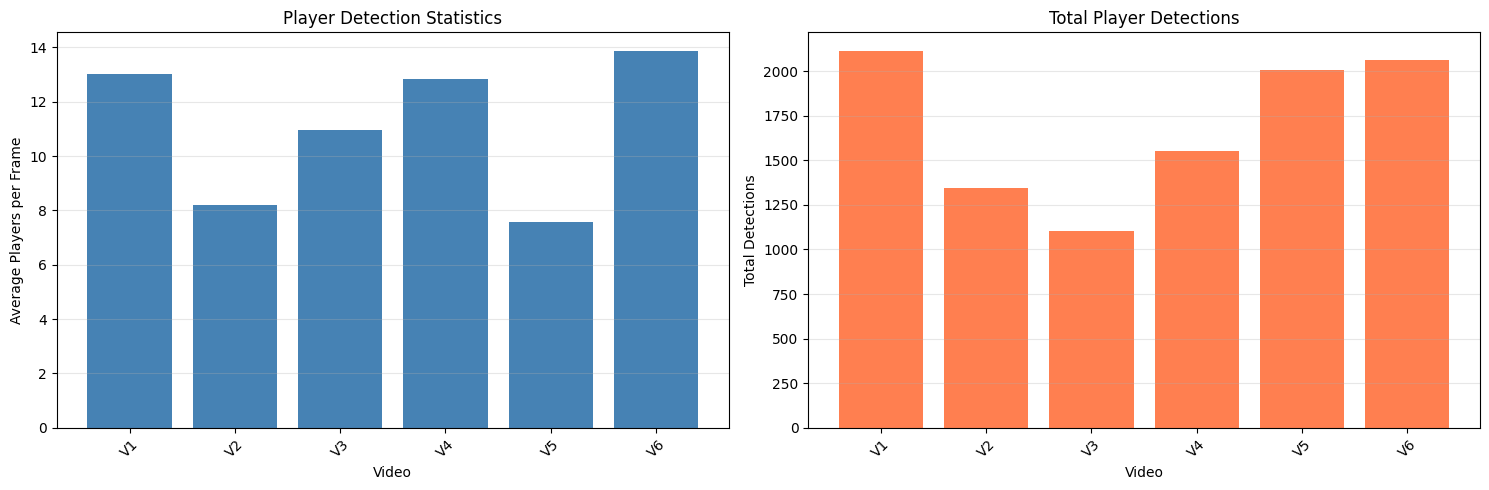

In [10]:


import matplotlib.pyplot as plt
import numpy as np

if 'all_detection_results' in locals() and len(all_detection_results) > 0:
    # Create visualization
    num_videos = len(all_detection_results)
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Average players per video
    video_names = list(all_detection_results.keys())
    avg_players = [all_detection_results[v]['avg_players_per_frame'] for v in video_names]

    axes[0].bar(range(len(video_names)), avg_players, color='steelblue')
    axes[0].set_xlabel('Video')
    axes[0].set_ylabel('Average Players per Frame')
    axes[0].set_title('Player Detection Statistics')
    axes[0].set_xticks(range(len(video_names)))
    axes[0].set_xticklabels([f'V{i+1}' for i in range(len(video_names))], rotation=45)
    axes[0].grid(axis='y', alpha=0.3)

    # Plot 2: Total detections per video
    total_dets = [all_detection_results[v]['total_detections'] for v in video_names]

    axes[1].bar(range(len(video_names)), total_dets, color='coral')
    axes[1].set_xlabel('Video')
    axes[1].set_ylabel('Total Detections')
    axes[1].set_title('Total Player Detections')
    axes[1].set_xticks(range(len(video_names)))
    axes[1].set_xticklabels([f'V{i+1}' for i in range(len(video_names))], rotation=45)
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()

    # Save figure
    stats_path = os.path.join(DIRECTORIES['report'], 'detection_statistics.png')
    plt.savefig(stats_path, dpi=300, bbox_inches='tight')
    print(f"✓ Statistics visualization saved to: {stats_path}")

    plt.show()
else:
    print("  No detection results available. Run detection first.")

In [11]:

POSE_PARAMS = {
    'conf': 0.25,        # Confidence threshold
    'iou': 0.45,         # IoU threshold for NMS
    'device': device,    # Use GPU if available
    'verbose': False,    # Reduce console output
    'save': True,        # Save annotated videos with keypoints
}

# YOLOv8-Pose detects 17 keypoints (COCO format):
KEYPOINT_NAMES = [
    'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
    'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
]

print("Pose Estimation Parameters:")

for key, value in POSE_PARAMS.items():
    print(f"{key:15}: {value}")
print(f"\nKeypoints detected: {len(KEYPOINT_NAMES)}")
print(f"Keypoint list: {', '.join(KEYPOINT_NAMES)}")


Pose Estimation Parameters:
conf           : 0.25
iou            : 0.45
device         : cuda
verbose        : False
save           : True

Keypoints detected: 17
Keypoint list: nose, left_eye, right_eye, left_ear, right_ear, left_shoulder, right_shoulder, left_elbow, right_elbow, left_wrist, right_wrist, left_hip, right_hip, left_knee, right_knee, left_ankle, right_ankle


In [12]:

video_files = []
for ext in ['.mp4', '.avi', '.mov', '.MP4', '.AVI', '.MOV']:
    video_files.extend(glob.glob(os.path.join(DIRECTORIES['videos'], f'*{ext}')))

if len(video_files) == 0:
    print(" No videos found. Please upload videos first.")
else:
    print(f"\n{'='*70}")
    print(f"Running Pose Estimation on {len(video_files)} video(s)")
    print(f"{'='*70}\n")

    # Store results for all videos
    all_pose_results = {}

    for idx, video_path in enumerate(video_files, 1):
        video_name = os.path.basename(video_path)
        print(f"\n[{idx}/{len(video_files)}] Processing: {video_name}")
        print("-" * 70)

        # Run pose estimation
        results = pose_model.predict(
            source=video_path,
            conf=POSE_PARAMS['conf'],
            iou=POSE_PARAMS['iou'],
            device=POSE_PARAMS['device'],
            save=True,
            project=DIRECTORIES['pose'],
            name=f"video_{idx}",
            exist_ok=True
        )

        # Process and store results
        video_results = {
            'video_name': video_name,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'total_frames': len(results),
            'poses_per_frame': []
        }

        total_poses = 0
        total_keypoints_detected = 0

        for frame_idx, result in enumerate(results):
            if result.keypoints is not None:
                num_poses = len(result.keypoints)
                total_poses += num_poses

                frame_data = {
                    'frame': frame_idx,
                    'num_poses': num_poses,
                    'poses': []
                }

                # Extract keypoint data for each detected person
                for pose_idx in range(num_poses):
                    keypoints = result.keypoints.xy[pose_idx].cpu().numpy()  # Shape: (17, 2)
                    confidences = result.keypoints.conf[pose_idx].cpu().numpy()  # Shape: (17,)

                    # Count valid keypoints (confidence > 0.5)
                    valid_keypoints = np.sum(confidences > 0.5)
                    total_keypoints_detected += valid_keypoints

                    pose_data = {
                        'pose_id': pose_idx,
                        'keypoints_detected': int(valid_keypoints),
                        'avg_confidence': float(np.mean(confidences))
                    }

                    frame_data['poses'].append(pose_data)

                video_results['poses_per_frame'].append(frame_data)

        video_results['total_poses'] = total_poses
        video_results['avg_poses_per_frame'] = total_poses / len(results) if len(results) > 0 else 0
        video_results['total_keypoints_detected'] = int(total_keypoints_detected)

        all_pose_results[video_name] = video_results

        # Print summary
        print(f"  ✓ Frames processed: {len(results)}")
        print(f"  ✓ Total poses detected: {total_poses}")
        print(f"  ✓ Avg poses/frame: {video_results['avg_poses_per_frame']:.2f}")
        print(f"  ✓ Total keypoints: {total_keypoints_detected}")

    # Save complete pose results to JSON
    results_json_path = os.path.join(DIRECTORIES['pose'], 'pose_results.json')
    with open(results_json_path, 'w') as f:
        json.dump(all_pose_results, f, indent=2)

    print("Pose Estimation Complete!")

    print(f"✓ Annotated videos saved to: {DIRECTORIES['pose']}")
    print(f"✓ Results JSON saved to: {results_json_path}")



Running Pose Estimation on 6 video(s)


[1/6] Processing: 05.mp4
----------------------------------------------------------------------

WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/162) /content/drive/MyDrive/player tracking/dataset/videos/05.mp4: 320x640 (no detections), 26.0ms
video 1/1 (frame 2/162) /content/drive/MyDrive/player tracking/dataset/videos/05.mp4: 320x640 (no detections), 10.0ms
video 1/1 (frame 3/162) /content/drive/MyDrive/player tracking/dataset/videos/05.mp4:

✓ Statistics visualization saved to: /content/drive/MyDrive/player tracking/report/pose_statistics.png


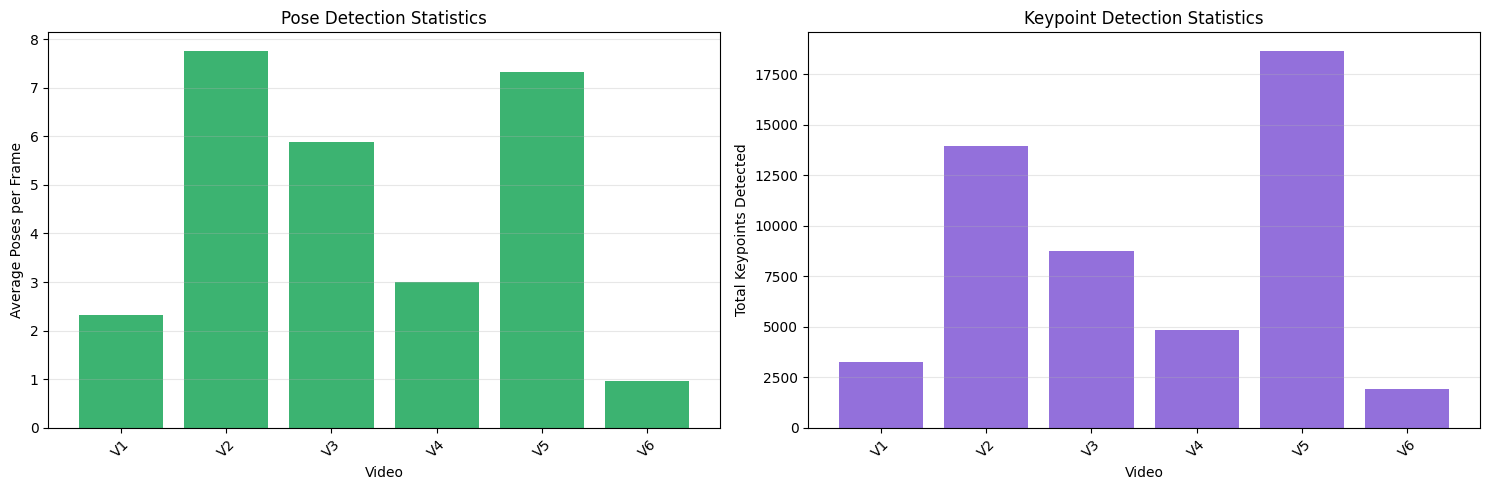

In [13]:


if 'all_pose_results' in locals() and len(all_pose_results) > 0:
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    video_names = list(all_pose_results.keys())

    # Plot 1: Average poses per video
    avg_poses = [all_pose_results[v]['avg_poses_per_frame'] for v in video_names]

    axes[0].bar(range(len(video_names)), avg_poses, color='mediumseagreen')
    axes[0].set_xlabel('Video')
    axes[0].set_ylabel('Average Poses per Frame')
    axes[0].set_title('Pose Detection Statistics')
    axes[0].set_xticks(range(len(video_names)))
    axes[0].set_xticklabels([f'V{i+1}' for i in range(len(video_names))], rotation=45)
    axes[0].grid(axis='y', alpha=0.3)

    # Plot 2: Total keypoints detected
    total_keypoints = [all_pose_results[v]['total_keypoints_detected'] for v in video_names]

    axes[1].bar(range(len(video_names)), total_keypoints, color='mediumpurple')
    axes[1].set_xlabel('Video')
    axes[1].set_ylabel('Total Keypoints Detected')
    axes[1].set_title('Keypoint Detection Statistics')
    axes[1].set_xticks(range(len(video_names)))
    axes[1].set_xticklabels([f'V{i+1}' for i in range(len(video_names))], rotation=45)
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()

    # Save figure
    stats_path = os.path.join(DIRECTORIES['report'], 'pose_statistics.png')
    plt.savefig(stats_path, dpi=300, bbox_inches='tight')
    print(f"✓ Statistics visualization saved to: {stats_path}")

    plt.show()
else:
    print("  No pose results available. Run pose estimation first.")

In [14]:

TRACKING_PARAMS = {
    'tracker': 'bytetrack.yaml',  # Use ByteTrack (can also use 'botsort.yaml')
    'conf': 0.25,
    'iou': 0.45,
    'classes': [0],  # Track only persons
    'device': device,
    'persist': True,  # Persist tracks between frames
}

print("Tracking Configuration:")

print("Tracker: ByteTrack (built into Ultralytics)")
print("Features:")
print("  - Assigns consistent IDs to players")
print("  - Handles occlusions and re-identification")
print("  - Works in real-time")
print("\nParameters:")
for key, value in TRACKING_PARAMS.items():
    print(f"{key:15}: {value}")


Tracking Configuration:
Tracker: ByteTrack (built into Ultralytics)
Features:
  - Assigns consistent IDs to players
  - Handles occlusions and re-identification
  - Works in real-time

Parameters:
tracker        : bytetrack.yaml
conf           : 0.25
iou            : 0.45
classes        : [0]
device         : cuda
persist        : True


In [15]:


video_files = []
for ext in ['.mp4', '.avi', '.mov', '.MP4', '.AVI', '.MOV']:
    video_files.extend(glob.glob(os.path.join(DIRECTORIES['videos'], f'*{ext}')))

if len(video_files) == 0:
    print("❌ No videos found. Please upload videos first.")
else:
    print(f"\n{'='*70}")
    print(f"Running Player Tracking on {len(video_files)} video(s)")
    print(f"{'='*70}\n")

    all_tracking_results = {}

    for idx, video_path in enumerate(video_files, 1):
        video_name = os.path.basename(video_path)
        print(f"\n[{idx}/{len(video_files)}] Processing: {video_name}")
        print("-" * 70)

        # Run tracking
        results = detection_model.track(
            source=video_path,
            tracker=TRACKING_PARAMS['tracker'],
            conf=TRACKING_PARAMS['conf'],
            iou=TRACKING_PARAMS['iou'],
            classes=TRACKING_PARAMS['classes'],
            device=TRACKING_PARAMS['device'],
            persist=TRACKING_PARAMS['persist'],
            save=True,
            project=DIRECTORIES['tracking'],
            name=f"video_{idx}",
            exist_ok=True
        )

        # Process tracking results
        video_results = {
            'video_name': video_name,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'total_frames': len(results),
            'unique_track_ids': set(),
            'tracks_per_frame': []
        }

        for frame_idx, result in enumerate(results):
            if result.boxes.id is not None:
                track_ids = result.boxes.id.cpu().numpy().astype(int).tolist()
                video_results['unique_track_ids'].update(track_ids)

                video_results['tracks_per_frame'].append({
                    'frame': frame_idx,
                    'num_tracks': len(track_ids),
                    'track_ids': track_ids
                })

        video_results['total_unique_players'] = len(video_results['unique_track_ids'])
        video_results['unique_track_ids'] = list(video_results['unique_track_ids'])

        all_tracking_results[video_name] = video_results

        # Print summary
        print(f"  ✓ Frames processed: {len(results)}")
        print(f"  ✓ Unique players tracked: {video_results['total_unique_players']}")
        print(f"  ✓ Track IDs: {video_results['unique_track_ids']}")

    # Save tracking results
    results_json_path = os.path.join(DIRECTORIES['tracking'], 'tracking_results.json')
    with open(results_json_path, 'w') as f:
        json.dump(all_tracking_results, f, indent=2, default=str)

    print("Tracking Complete!")

    print(f"✓ Tracked videos saved to: {DIRECTORIES['tracking']}")
    print(f"✓ Results JSON saved to: {results_json_path}")



Running Player Tracking on 6 video(s)


[1/6] Processing: 05.mp4
----------------------------------------------------------------------
requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 2 packages in 158ms
Prepared 1 package in 50ms
Installed 1 package in 2ms
 + lap==0.5.12

requirements: AutoUpdate success ✅ 0.6s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probab

In [16]:


def generate_performance_report():
    """
    Generate a comprehensive performance report combining:
    - Detection metrics
    - Pose estimation metrics
    - Tracking metrics (if available)
    """

    report = {
        'project': 'SC549 Player Tracking in Football Videos',
        'generated': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'models': {
            'detection': 'YOLOv8n',
            'pose': 'YOLOv8n-pose',
            'tracking': 'ByteTrack'
        },
        'device': device,
        'summary': {}
    }

    # Detection Summary
    if 'all_detection_results' in globals():
        total_videos = len(all_detection_results)
        total_frames = sum(v['total_frames'] for v in all_detection_results.values())
        total_detections = sum(v['total_detections'] for v in all_detection_results.values())
        avg_detections = total_detections / total_frames if total_frames > 0 else 0

        report['summary']['detection'] = {
            'total_videos': total_videos,
            'total_frames': total_frames,
            'total_detections': total_detections,
            'avg_detections_per_frame': round(avg_detections, 2)
        }

    # Pose Summary
    if 'all_pose_results' in globals():
        total_poses = sum(v['total_poses'] for v in all_pose_results.values())
        total_keypoints = sum(v['total_keypoints_detected'] for v in all_pose_results.values())

        report['summary']['pose'] = {
            'total_poses': total_poses,
            'total_keypoints': total_keypoints,
            'avg_keypoints_per_pose': round(total_keypoints / total_poses, 2) if total_poses > 0 else 0
        }

    # Tracking Summary
    if 'all_tracking_results' in globals():
        total_unique_players = sum(v['total_unique_players'] for v in all_tracking_results.values())

        report['summary']['tracking'] = {
            'total_unique_players_tracked': total_unique_players
        }

    return report

# Generate and save report
performance_report = generate_performance_report()
report_path = os.path.join(DIRECTORIES['report'], 'performance_report.json')

with open(report_path, 'w') as f:
    json.dump(performance_report, f, indent=2)

# Display report

print("PERFORMANCE REPORT")

print(json.dumps(performance_report, indent=2))

print(f"\n Report saved to: {report_path}\n")

PERFORMANCE REPORT
{
  "project": "SC549 Player Tracking in Football Videos",
  "generated": "2026-02-16 18:15:30",
  "models": {
    "detection": "YOLOv8n",
    "pose": "YOLOv8n-pose",
    "tracking": "ByteTrack"
  },
  "device": "cuda",
  "summary": {
    "detection": {
      "total_videos": 6,
      "total_frames": 961,
      "total_detections": 10188,
      "avg_detections_per_frame": 10.6
    },
    "pose": {
      "total_poses": 4682,
      "total_keypoints": 51412,
      "avg_keypoints_per_pose": 10.98
    },
    "tracking": {
      "total_unique_players_tracked": 494
    }
  }
}

 Report saved to: /content/drive/MyDrive/player tracking/report/performance_report.json



✓ Performance dashboard saved to: /content/drive/MyDrive/player tracking/report/performance_dashboard.png


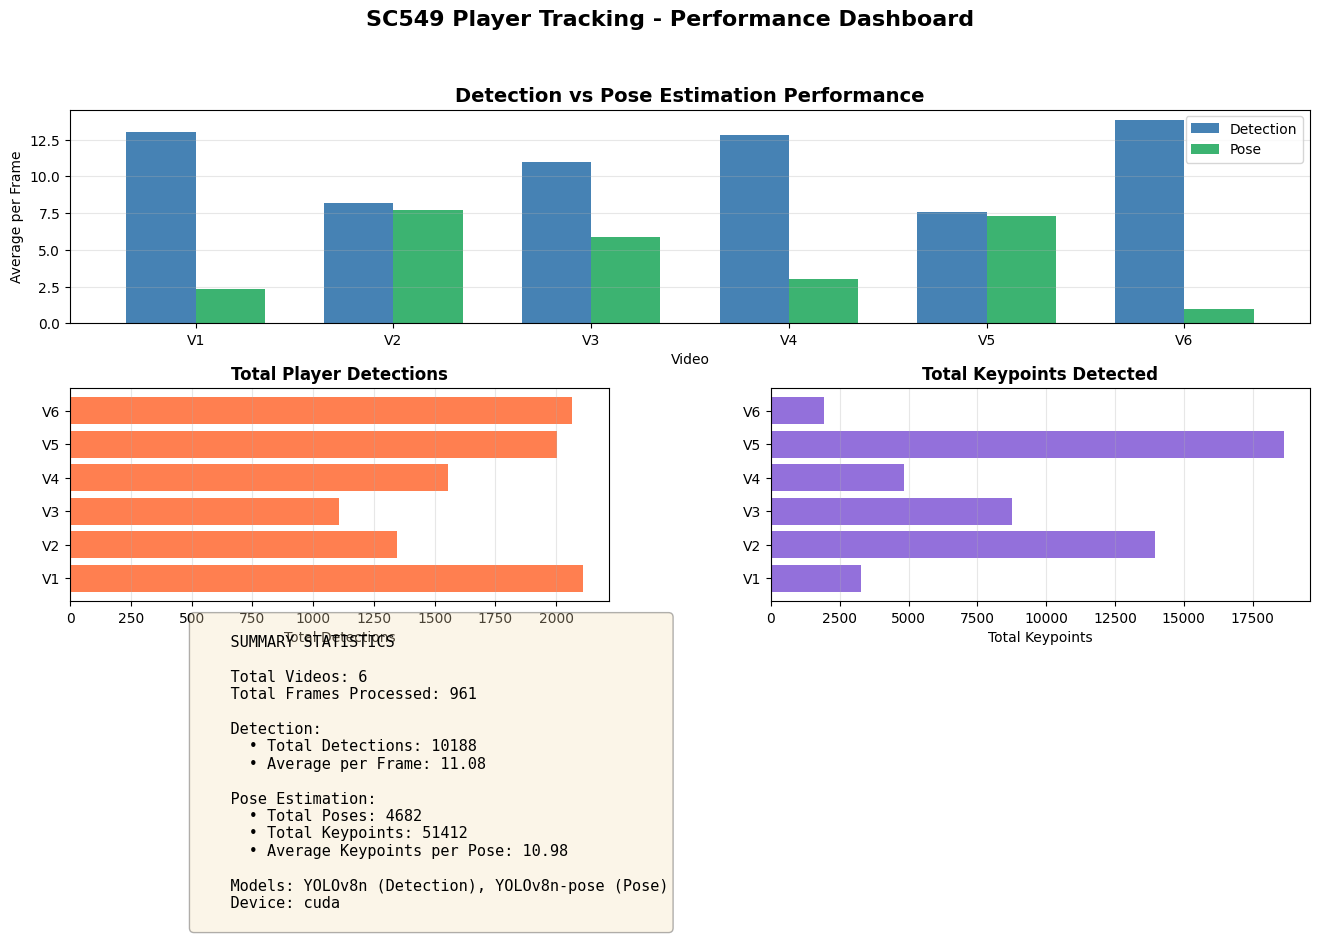

In [17]:


if 'all_detection_results' in globals() and 'all_pose_results' in globals():
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    video_names = list(all_detection_results.keys())

    # Plot 1: Detection comparison
    ax1 = fig.add_subplot(gs[0, :])
    x = np.arange(len(video_names))
    width = 0.35

    det_counts = [all_detection_results[v]['avg_players_per_frame'] for v in video_names]
    pose_counts = [all_pose_results[v]['avg_poses_per_frame'] for v in video_names]

    ax1.bar(x - width/2, det_counts, width, label='Detection', color='steelblue')
    ax1.bar(x + width/2, pose_counts, width, label='Pose', color='mediumseagreen')
    ax1.set_xlabel('Video')
    ax1.set_ylabel('Average per Frame')
    ax1.set_title('Detection vs Pose Estimation Performance', fontweight='bold', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'V{i+1}' for i in range(len(video_names))])
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # Plot 2: Total detections
    ax2 = fig.add_subplot(gs[1, 0])
    total_det = [all_detection_results[v]['total_detections'] for v in video_names]
    ax2.barh(range(len(video_names)), total_det, color='coral')
    ax2.set_yticks(range(len(video_names)))
    ax2.set_yticklabels([f'V{i+1}' for i in range(len(video_names))])
    ax2.set_xlabel('Total Detections')
    ax2.set_title('Total Player Detections', fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    # Plot 3: Keypoint detection
    ax3 = fig.add_subplot(gs[1, 1])
    total_kp = [all_pose_results[v]['total_keypoints_detected'] for v in video_names]
    ax3.barh(range(len(video_names)), total_kp, color='mediumpurple')
    ax3.set_yticks(range(len(video_names)))
    ax3.set_yticklabels([f'V{i+1}' for i in range(len(video_names))])
    ax3.set_xlabel('Total Keypoints')
    ax3.set_title('Total Keypoints Detected', fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)

    # Plot 4: Summary statistics
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('off')

    summary_text = f"""
    SUMMARY STATISTICS

    Total Videos: {len(video_names)}
    Total Frames Processed: {sum(v['total_frames'] for v in all_detection_results.values())}

    Detection:
      • Total Detections: {sum(v['total_detections'] for v in all_detection_results.values())}
      • Average per Frame: {np.mean([v['avg_players_per_frame'] for v in all_detection_results.values()]):.2f}

    Pose Estimation:
      • Total Poses: {sum(v['total_poses'] for v in all_pose_results.values())}
      • Total Keypoints: {sum(v['total_keypoints_detected'] for v in all_pose_results.values())}
      • Average Keypoints per Pose: {sum(v['total_keypoints_detected'] for v in all_pose_results.values()) / sum(v['total_poses'] for v in all_pose_results.values()):.2f}

    Models: YOLOv8n (Detection), YOLOv8n-pose (Pose)
    Device: {device}
    """

    ax4.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    plt.suptitle('SC549 Player Tracking - Performance Dashboard',
                 fontsize=16, fontweight='bold', y=0.98)

    # Save dashboard
    dashboard_path = os.path.join(DIRECTORIES['report'], 'performance_dashboard.png')
    plt.savefig(dashboard_path, dpi=300, bbox_inches='tight')
    print(f"✓ Performance dashboard saved to: {dashboard_path}")

    plt.show()
else:
    print("  Run detection and pose estimation first to generate dashboard.")